In [1]:
import ee
import geopandas as gpd
import folium
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import rasterio as rio
from rasterio.plot import show

In [2]:
ee.Authenticate(auth_mode='notebook')

True

In [3]:
# Initialize Earth Engine
ee.Initialize(project='turnkey-girder-247613')  # Replace with your actual Project ID from Step 1

In [4]:
ee.Initialize()  # This uses your authenticated credentials
print("Earth Engine initialized successfully!")

Earth Engine initialized successfully!


In [5]:
# Define ROI as a GeoJSON polygon (example: a forested area; replace with your coords)
roi = ee.Geometry.Polygon(
    [[[ 22.348489, 46.044738 ], [ 22.461584, 46.043410 ], [ 22.463922, 45.953032 ], [ 22.341899, 45.959682 ]]]  # Example: Petris - Hunedoara area forest
)

# Define date range (e.g., summer months for clear imagery)
start_date = '2023-06-01'
end_date = '2023-09-01'

print("The boundaries are defined!")

The boundaries are defined!


In [6]:
# Load collection (unchanged)
collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
              .filterBounds(roi)
              .filterDate(start_date, end_date)
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
              .sort('CLOUDY_PIXEL_PERCENTAGE'))

def process_image(img):
    # Standard Cloud Masking (keeping your existing logic)
    cloud_mask = img.select('MSK_CLDPRB').lt(20)
    img_masked = img.updateMask(cloud_mask).divide(10000)
    
    # 1. Existing NDVI (Vegetation)
    ndvi = img_masked.normalizedDifference(['B8', 'B4']).rename('NDVI')
    
    # 2. Add NDWI (Water - helps with your 1.00 water precision)
    ndwi = img_masked.normalizedDifference(['B3', 'B8']).rename('NDWI')
    
    # 3. Add NDBI (Built-up - crucial for Roads and Villages)
    # Formula: (SWIR1 - NIR) / (SWIR1 + NIR)
    ndbi = img_masked.normalizedDifference(['B11', 'B8']).rename('NDBI')
    
    # Add all bands together
    return img_masked.addBands([ndvi, ndwi, ndbi]).select([
        'B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'NDVI', 'NDWI', 'NDBI'
    ])

# Apply processing to every image in the collection
processed_collection = collection.map(process_image)

# Create the final composite (now with NDVI already included in each image)
image = processed_collection.median()

print("Composite with NDVI, NDWI, NDBI created successfully.")

Composite with NDVI, NDWI, NDBI created successfully.


In [7]:

# Load from GeoJSON (preferred—preserves geometry)
training_data = gpd.read_file('geojson/trained_data.geojson')

# Ensure CRS is WGS84 (lon/lat)
training_data = training_data.to_crs('EPSG:4326')

# Convert to EE FeatureCollection
# Extract lon/lat from geometry and class from attribute
training_points = ee.FeatureCollection([
    ee.Feature(ee.Geometry.Point(row['geometry'].x, row['geometry'].y), {'class': row['class']})
    for _, row in training_data.iterrows()
])

# If using CSV (columns: lon, lat, class)
# import pandas as pd
# training_data = pd.read_csv('training_points.csv')
# training_points = ee.FeatureCollection([
#     ee.Feature(ee.Geometry.Point(row['lon'], row['lat']), {'class': row['class']})
#     for _, row in training_data.iterrows()
# ])

# Sample the image at these points (as in original code)
sampled = image.sampleRegions(collection=training_points, properties=['class'], scale=10)

print("Training points imported and sampled.")

Training points imported and sampled.


In [8]:
# From previous steps: Ensure 'sampled' is defined (image.sampleRegions(...))

# Start the export task to Google Drive
task = ee.batch.Export.table.toDrive(
    collection=sampled,
    description='sampled_data_v5',  # Name for the task
    fileFormat='CSV'  # Or 'GeoJSON' if you prefer
)
task.start()

print("Export task started. Check the GEE Tasks panel for progress.")

Export task started. Check the GEE Tasks panel for progress.


In [9]:
import pandas as pd

# Load the CSV (adjust path if it's not in the current directory)
df = pd.read_csv('sampled_data/sampled_data_v5.csv')

# Drop unnecessary GEE-added columns if present
if 'system:index' in df.columns:
    df = df.drop(columns=['system:index'])

# Define your bands (match what you used earlier)
bands = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'NDVI', 'NDWI', 'NDBI']

# Features and labels
X = df[bands]
y = df['class']

# Inspection (run this to check data quality)
print(df.head())
print("Class distribution:\n", y.value_counts())
print("Missing values:", X.isnull().sum().sum())  # Handle with df.dropna() if any

print("Data loaded!")

       B11      B12       B2       B3       B4       B8      NDBI      NDVI  \
0  0.17030  0.06860  0.02310  0.03640  0.02015  0.33765 -0.339740  0.888873   
1  0.09585  0.03735  0.02325  0.03295  0.01705  0.25120 -0.451620  0.875194   
2  0.18765  0.07150  0.02720  0.04780  0.02115  0.48720 -0.454526  0.918660   
3  0.16730  0.06720  0.02015  0.03115  0.01655  0.32320 -0.324069  0.903236   
4  0.17200  0.06410  0.02385  0.04015  0.01715  0.42280 -0.423425  0.922530   

       NDWI   class                                    .geo  
0 -0.810055  forest  {"type":"MultiPoint","coordinates":[]}  
1 -0.768252  forest  {"type":"MultiPoint","coordinates":[]}  
2 -0.826663  forest  {"type":"MultiPoint","coordinates":[]}  
3 -0.831222  forest  {"type":"MultiPoint","coordinates":[]}  
4 -0.830743  forest  {"type":"MultiPoint","coordinates":[]}  
Class distribution:
 class
agriculture    189
forest          55
pastures        54
village         40
rails           35
stone_quary     33
roads       

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest
# Set oob_score=True
classifier = RandomForestClassifier(n_estimators=200, random_state=42, oob_score=True)
classifier.fit(X_train, y_train)

print(f"OOB Score: {classifier.oob_score_:.4f}")

OOB Score: 0.8370


Accuracy: 0.8152173913043478

Classification Report:
               precision    recall  f1-score   support

 agriculture       0.87      0.87      0.87        38
      forest       1.00      0.82      0.90        11
    pastures       0.69      1.00      0.81        11
       rails       0.75      0.86      0.80         7
       roads       0.67      0.33      0.44         6
 stone_quary       0.67      1.00      0.80         6
     village       0.75      0.38      0.50         8
       water       1.00      1.00      1.00         5

    accuracy                           0.82        92
   macro avg       0.80      0.78      0.77        92
weighted avg       0.82      0.82      0.80        92



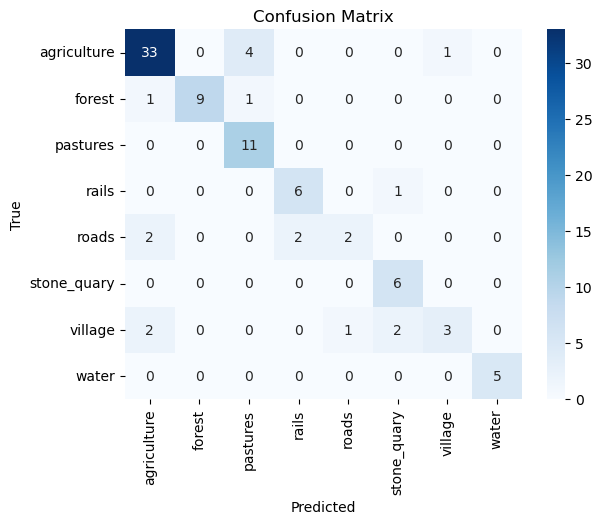

In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict and evaluate
y_pred = classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [12]:
# After creating your final image (with NDVI added, bands selected, etc.)
# Cast the whole image to Float32
image = image.toFloat()  # or image.float() — both work

# Now export
task = ee.batch.Export.image.toDrive(
    image=image,
    description='sentinel_image_v5',
    scale=10,
    region=roi,
    fileFormat='GeoTIFF',
    maxPixels=1e9  # adjust if needed
)
task.start()

print("Export task started with consistent Float32 bands.")

Export task started with consistent Float32 bands.


In [13]:
import numpy as np
import rasterio as rio

# Load the TIFF
with rio.open('raster/sentinel_image_v5.tif') as src:
    img_array = src.read()  # Shape: (bands, height, width)
    img_meta = src.meta  # Save metadata (CRS, transform, etc.)
    img_array = np.moveaxis(img_array, 0, -1)  # Reshape to (height, width, bands) for easier processing
    height, width, num_bands = img_array.shape

# Reshape to 2D array for prediction (each row is a pixel's band values)
img_reshaped = img_array.reshape(-1, num_bands)  # Shape: (height*width, bands)

print("Image loaded. Shape:", img_array.shape)

Image loaded. Shape: (1022, 1360, 9)


In [14]:
# Predict classes for all pixels (using your trained classifier from Step 5)
classified_flat = classifier.predict(img_reshaped)

# Reshape back to image dimensions
classified = classified_flat.reshape(height, width)

# Map string classes to integers for raster storage (GeoTIFFs prefer numeric; create a legend)
class_map = {label: idx for idx, label in enumerate(classifier.classes_)}  # e.g., {'agriculture':0, 'forest':1, ...}
classified_numeric = np.vectorize(class_map.get)(classified).astype(np.uint8)  # Convert to numbers

print("Classification complete. Unique classes:", np.unique(classified))

C:\Users\adrian.juravlea\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification complete. Unique classes: ['agriculture' 'forest' 'pastures' 'rails' 'roads' 'stone_quary' 'village'
 'water']


In [15]:
# Update metadata for single-band output
img_meta.update({
    'count': 1,  # Single band (classified values)
    'dtype': 'uint8'  # 0-255 integers
})

# Write to new GeoTIFF
with rio.open('raster/classified_land_cover_v5.tif', 'w', **img_meta) as dst:
    dst.write(classified_numeric, 1)  # Write the array to band 1

print("Classified raster saved as 'classified_land_cover.tif_v5'.")

Classified raster saved as 'classified_land_cover.tif_v5'.


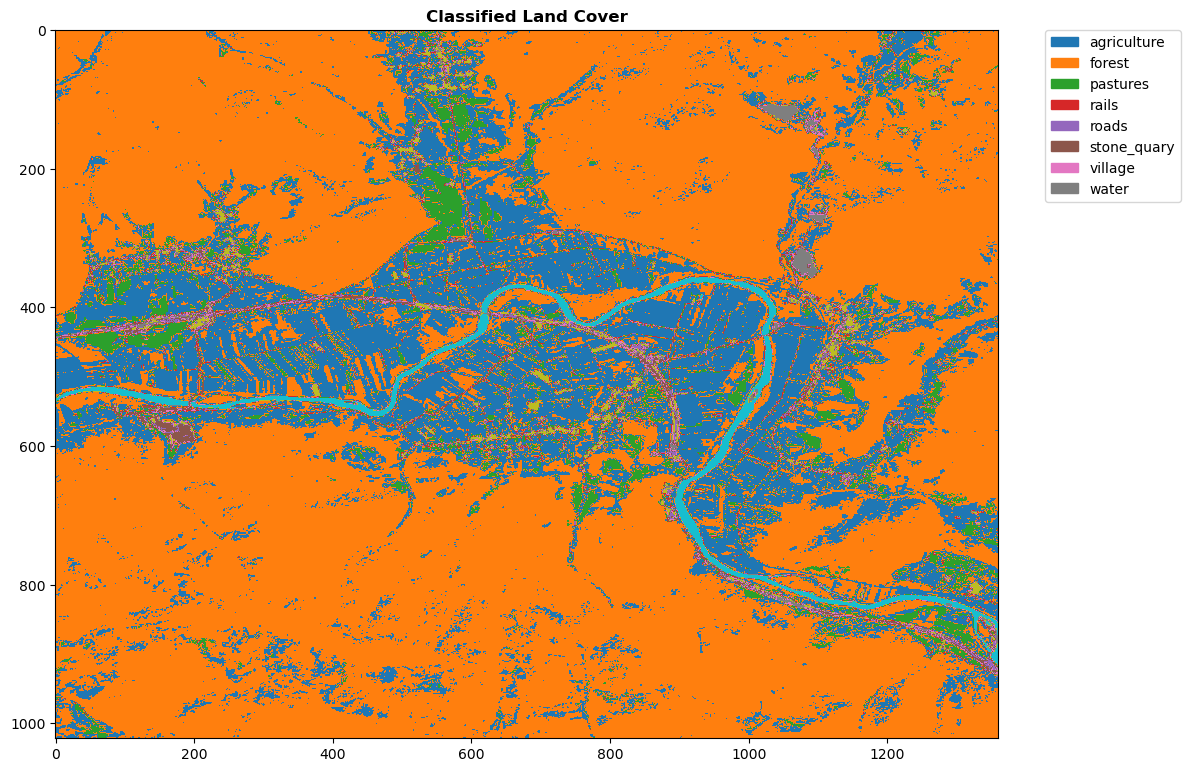

agriculture: 316997 pixels (~3170.0 ha)
forest: 931604 pixels (~9316.0 ha)
pastures: 68510 pixels (~685.1 ha)
rails: 9796 pixels (~98.0 ha)
roads: 20877 pixels (~208.8 ha)
stone_quary: 5463 pixels (~54.6 ha)
village: 19270 pixels (~192.7 ha)
water: 17403 pixels (~174.0 ha)


In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from rasterio.plot import show
import numpy as np

# 1. Setup the figure
fig, ax = plt.subplots(figsize=(12, 10))

# 2. Display the image
# We use the same cmap as before
im = show(classified_numeric, ax=ax, cmap='tab10', title='Classified Land Cover')

# 3. Create the Legend
# Get the colormap colors used in the plot
cmap = plt.get_cmap('tab10')

# Create a list of patches (colored boxes) for the legend
legend_patches = []
for class_name, val in class_map.items():
    # Only add to legend if the class actually exists in your numeric array
    if val in unique:
        color = cmap(val / 10.0) # tab10 has 10 colors, we normalize the index
        patch = mpatches.Patch(color=color, label=class_name)
        legend_patches.append(patch)

# Add the legend to the plot
ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

# Keep your area stats code below
unique, counts = np.unique(classified_numeric, return_counts=True)
for u, c in zip(unique, counts):
    class_name = [k for k, v in class_map.items() if v == u][0] if u in class_map.values() else 'unknown'
    area_ha = (c * 100) / 10000 
    print(f"{class_name}: {c} pixels (~{area_ha:.1f} ha)")